# Distance Based Statistical Method for Planar Point Patterns

**Authors: Serge Rey <sjsrey@gmail.com> and Wei Kang <weikang9009@gmail.com>**

## Introduction

Distance based methods for point patterns are of three types:

* [Mean Nearest Neighbor Distance Statistics](#Mean-Nearest-Neighbor-Distance-Statistics)
* [Nearest Neighbor Distance Functions](#Nearest-Neighbor-Distance-Functions)
* [Interevent Distance Functions](#Interevent-Distance-Functions)

In addition, we are going to introduce a computational technique [Simulation Envelopes](#Simulation-Envelopes) to aid in making inferences about the data generating process. An [example](#CSR-Example) is used to demonstrate how to use and interprete simulation envelopes.

In [1]:
from scipy import spatial
import libpysal as ps
import numpy as np
from pointpats import ripley
%matplotlib inline
import matplotlib.pyplot as plt

## Mean Nearest Neighbor Distance Statistics

The nearest neighbor(s) for a point $u$ is the point(s) $N(u)$ which meet the condition
$$d_{u,N(u)} \leq d_{u,j} \forall j \in S - u$$

The distance between the nearest neighbor(s) $N(u)$ and the point $u$ is nearest neighbor distance for $u$. After searching for nearest neighbor(s) for all the points and calculating the corresponding distances, we are able to calculate mean nearest neighbor distance by averaging these distances.

It was demonstrated by Clark and Evans(1954) that mean nearest neighbor distance statistics distribution is a normal distribution under null hypothesis (underlying spatial process is CSR). We can utilize the test statistics to determine whether the point pattern is the outcome of CSR. If not, is it the outcome of cluster or regular
spatial process?

In [2]:
points = np.array([[66.22, 32.54], [22.52, 22.39], [31.01, 81.21],
                   [9.47, 31.02],  [30.78, 60.10], [75.21, 58.93],
                   [79.26,  7.68], [8.23, 39.93],  [98.73, 77.17],
                   [89.78, 42.53], [65.19, 92.08], [54.46, 8.48]])

## Nearest Neighbor Distance Functions

Nearest neighbour distance distribution functions (including the nearest “event-to-event” and “point-event” distance distribution functions) of a point process are cumulative distribution functions of several kinds -- $G, F, J$. By comparing the distance function of the observed point pattern with that of the point pattern from a CSR process, we are able to infer whether the underlying spatial process of the observed point pattern is CSR or not for a given confidence level.

#### $G$ function - event-to-event

The $G$ function is a kind of "cumulative" density describing the distribution of distances within a point pattern. For a given distance $d$, $G(d)$ is the proportion of nearest neighbor distances that are less than $d$. To express this, we first need to define the nearest neighbor distance, which is the smallest distance from each observation $i$ to some other observation $j$, where $j \neq i$:
$$ min_{j\neq i}\{d_{ij}\} = d^*_i $$

With this, we can define the $G$ function as a cumulative density function:
$$G(d) = \frac{1}{N}\sum_{i=1}^N \mathcal{I}(d^*_i < d)$$
where $\mathcal{I}(.)$ is an *indicator function* that is $1$ when the argument is true and is zero otherwise. In simple terms, $G(d)$ gives the percentage of of nearest neighbor distances ($d^*_i$) that are smaller than $d$; when $d$ is very small, $G(d)$ is close to zero. When $d$ is large, $G(d)$ approaches one.  

Analytical results about $G$ are available assuming that the "null" process of locating points in the study area is completely spatially random. In a completely spatially random process, the $G(d)$ value should be:
$$
G(d) = 1-e^{-\lambda \pi d^2}
$$
Practically, we assess statistical significance for the $G(d)$ function using simulations, where a known spatially-random process is generated and then analyzed. This partially accounts for issues with irregularly-shaped study areas, where locations of points are constrained. 

In practice, we use the `ripley.g_test` function to conduct a test on the $G(d)$. It estimates a value of $G(d)$ for a set of values (called the `support`). To compute the $G$ function for ten values of $d$ ranging from the smallest possible to the largest values in the data:

In [3]:
g_test = ripley.g_test(points, support=10)

All statistical tests in the `pointpats.distance_statistics` return a `collections.namedtuple` object with the following properties:
- `support`, which contains the distance values ($d$) used to compute the distance statistic. 
- `statistic`, which expresses the value of the requested function at each value of $d$ in the `support`. 
- `pvalue`, which expresses the fraction of observed simulations (under a completely spatially random process) that are more extreme than the observed statistics. 
- `simulations`, which stores the simulated values of the statistic under a spatially random process. Generally, this is *not* saved (for efficiency reasons), but can be requested using `keep_simulations`. 

In [4]:
g_test.support

array([ 0.        ,  3.84791574,  7.69583148, 11.54374723, 15.39166297,
       19.23957871, 23.08749445, 26.93541019, 30.78332593, 34.63124168])

In [5]:
g_test.statistic

array([0.        , 0.        , 0.        , 0.16666667, 0.16666667,
       0.25      , 0.58333333, 0.83333333, 0.91666667, 1.        ])

In [6]:
g_test.pvalue

array([0.00e+00, 0.00e+00, 0.00e+00, 2.89e-02, 1.10e-03, 1.00e-04,
       4.30e-03, 6.10e-02, 7.33e-02, 0.00e+00])

In [7]:
g_test.simulations

To make a plot of the statistic, the `statistic` is generally plotted on the vertical axis and the `support` on the horizontal axis. Here, we will show the median simulated value of $G(d)$ as well.

In [8]:
g_test = ripley.g_test(points, support=10, keep_simulations=True)

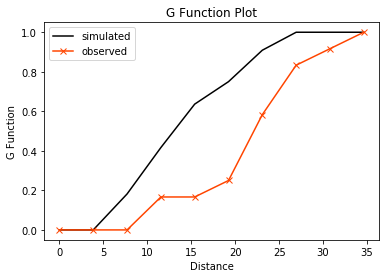

In [9]:
plt.plot(g_test.support, np.median(g_test.simulations, axis=0), 
         color='k', label='simulated')
plt.plot(g_test.support, g_test.statistic, 
         marker='x', color='orangered', label='observed')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('G Function')
plt.title('G Function Plot')
plt.show()

As you can see, the $G$ function increases very slowly at small distances and the line is below the typical simulated value (shown in black). We can verify the visual intuition here by looking at the p-value for each point and plotting the simulated $G(d)$ curves, too:

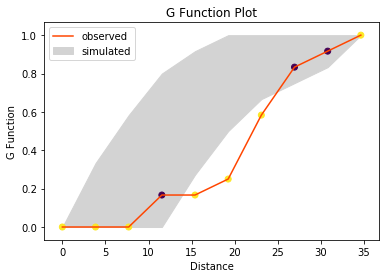

In [10]:
# grab the middle 95% of simulations using numpy:
middle_95pct = np.percentile(g_test.simulations, q=(2.5, 97.5), axis=0)
# use the fill_between function to color between the 2.5% and 97.5% envelope
plt.fill_between(g_test.support, *middle_95pct, 
                 color='lightgrey', label='simulated')

# plot the line for the observed value of G(d)
plt.plot(g_test.support, g_test.statistic, 
         color='orangered', label='observed')
# and plot the support points depending on whether their p-value is smaller than .05
plt.scatter(g_test.support, g_test.statistic, 
            cmap='viridis', c=g_test.pvalue < .01)
plt.legend()
plt.xlabel('Distance')
plt.ylabel('G Function')
plt.title('G Function Plot')
plt.show()

From this, we can see that there is statistically significant "dispersion" at small values of $d$, since there are *too few* nearest neighbor distances observed between $0 < d < 25$. Once we get to very large distances, the simulation envelope covers the observed statistic. As such, we can say that the point pattern recorded in `points` is unusally dispersed. 

To evaluate the $G(d)$ function without considering any statistical significance or simulations, you can use the `g_function` in the `ripley` module, which simply returns the distances & values of $G(d)$. 

In [11]:
ripley.g_function(points)

(array([ 0.        ,  1.82269693,  3.64539386,  5.46809079,  7.29078772,
         9.11348465, 10.93618158, 12.75887851, 14.58157544, 16.40427237,
        18.2269693 , 20.04966623, 21.87236316, 23.69506009, 25.51775702,
        27.34045395, 29.16315088, 30.98584782, 32.80854475, 34.63124168]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.25      ,
        0.25      , 0.25      , 0.41666667, 0.58333333, 0.75      ,
        0.83333333, 0.83333333, 0.91666667, 0.91666667, 1.        ]))

#### $F$ function - "point-event" 

When the number of events in a point pattern is small, $G$ function is rough. For the pattern contained in `points`, there are only 12 observations! This means that there are only 12 nearest neighbor distances, and thus only 12 possible values for the $G(d)$ statistic, at any $d$. 

One way to get around this is to turn to an alternative, the $F(d)$ function. This is analogous to the $G(d)$ function, but measures the nearest neighbor distance *from* a set of known randomly-distributed points *to* a point in the observed pattern. Another way of thinking about $F(d)$ is that it reflects a *between-pattern* measure of dispersion, where one pattern is completely spatially random and the other pattern is our observed pattern. In contrast, $G(d)$ is a *within-pattern* measure of dispersion. 

For a randomly simulated point pattern of size $N_s$, this makes the $F(d)$ function:

$$F(d) = \frac{1}{N_s} \sum_k^{N_s} \mathcal{I}(d^*_k < d)$$

This can have $N_s$ possible values for any $d$, and thus can give a much more fine-grained view of the point pattern. In this sense, the $F(d)$ function is often called the *empty space function*, as it measures the distance from random points in "empty space" to the "filled" points in our point pattern. The number of those random points governs how "fine-grained" our measure of the observed point pattern can be. 

Just like the `ripley.g_test`, this function is evaluated for every $d$ in a support. Further, we can provide *custom* values for `support`, just in case we have known distance values of interest. 

Below, we'll use the same ten `support` values from $G(d)$ function. And, let's constrain the "simulated" point patterns to fall within the convex hull of our original point pattern: 

In [12]:
f_test = ripley.f_test(points, support = g_test.support, keep_simulations=True, hull='convex')

Since the $F(d)$ function is very smooth, we can see the $F(d)$ statistic and its simulations clearly by plotting their values directly as lines. For the simulated values, we will make them very transparent. As before we will visualize statistical significance using the `pvalue` attribute:

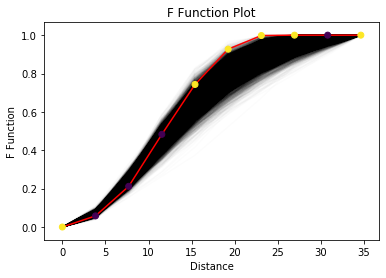

In [13]:
plt.plot(f_test.support, f_test.simulations.T, alpha=.01, color='k')
plt.plot(f_test.support, f_test.statistic, color='red')

plt.scatter(f_test.support, f_test.statistic, 
            cmap='viridis', c=f_test.pvalue < .05,
            zorder=4 # make sure they plot on top
           )

plt.xlabel('Distance')
plt.ylabel('F Function')
plt.title('F Function Plot')
plt.show()

plt.show()

From this we see that the values of the $F$ function are *too high* for distances from about 15 to 25, and (in contrast) for values between $5 < d < 10$, the $F(d)$ function has too few short distances. When the observed $F(d)$ values are too large, then the pattern is too dispersed, or regular. If the empirical $F(d)$ tends to fall below the simulated values, then it reflects clustering. This is the *opposite* of the interpretation of the $G(d)$ function above, so be careful!

#### $J$ function - a combination of "event-event" and "point-event"

The $J$ function combines the $G$ and $F$ function, in an attempt to provide an immediate graphical indication of the clustering both internally and with respect to the empty space distribution. Practically, the $J(d)$ function is computed as a kind of "relative clustering ratio":

$$J(d) = \frac{1-G(d)}{1-F(d)}$$

where the numerator captures the clustering due to within-pattern distances and the denominator captures that for the pattern-to-empty distances. This means that when $J(d)<1$, the underlying point process is a cluster point process, and when $J(d)=1$, the underlying point process is a random point process; otherwise, it is a dispersed point process.

This function can suffer from numerical stability issues; as $G(d)$ and $F(d)$ both approach $1$, the $J$ ratio can become chaotic. Further, when $G$ or $F$ reaches one, the $J$ function changes abruptly. As such, the $J$ function is often *truncated* to the first $1$ (either in $F(d)$ or $G(d)$), and any $d$ where both $F$ and $G$ are $1$ is assigned a $J$ value of $1$. 

In [14]:
jp1 = ripley.j_test(points, support=20)

/home/lw17329/Dropbox/dev/pointpats/pointpats/ripley.py:894: UserWarning: requested 20 bins to evaluate the J function, but it reaches infinity at d=25.5178, meaning only 14 bins will be used to characterize the J function.
  tree, distances=distances, **core_kwargs


As you can see from the warning above, the $J$ function did encounter numerical stability issues at about $d=25$. To address this, `pointpats` truncated the $J$ function to only have 14 values in its support, rather than the $20$ requested. 

Text(0, 0.5, 'J Function')

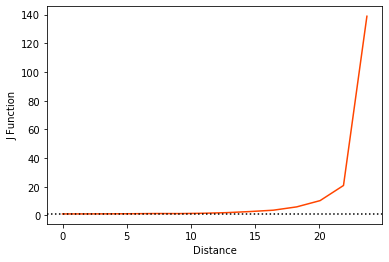

In [15]:
plt.plot(jp1.support, jp1.statistic, color='orangered')
plt.axhline(1, linestyle=':', color='k')
plt.xlabel('Distance')
plt.ylabel('J Function')

From the above figure, we see that the $J$ function is above the $J(d)=1$ horizontal line, especially as $d$ gets large. This suggests that the process is over-dispersed. 

## Interevent Distance Functions

While both the $F(d)$ and $G(d)$ functions are useful, they only consider the distance between each point $i$ and its nearest point. Earlier we spelled this distance $d_i^*$, and the distance between $i$ and $j$ was $d_{ij}$. So, note that $d_{i}^*$ is the *only* term that matters for $F$ and $G$, if $d_{ij}$ changes (but $j$ isn't closest to $i$), then the $F$ and $G$ functions generally remain the same. 

So, further statistical summary functions have been developed to consider the *whole* distance distribution, not only the nearest neighbor distances. These functions (still considered part of the "Ripley" alphabet, are the $K$, and $L$ functions. 

#### $K$ function

The $K(d)$ function is a scaled version of the cumulative density function for *all* distances within a point pattern. As such, it's a "relative" of the $G$ function that considers all distances, not just the nearest neighbor distances. Practically, the $K(d)$ function can be thought of as the percentage of all distances that are less than $d$. Therefore, for a threshold distance $d$, the $K$ function is defined as:

$$K(d) = \frac{1}{N\hat\lambda} \underset{i=1}{\overset{N}{\sum}}\underset{j=1}{\overset{N}{\sum}} \mathcal{I}\left(d_ij < d\right)$$

In this equation, $\hat\lambda$ is the *intensity* of the point process. This represents how many points (on average) you would expect in a unit area. You can think of this as an analogue to the *density* of the points in the pattern: large values of $\hat\lambda$ mean many points per area, and small values of $\hat\lambda$ mean there are fewer points per area. Generally, this parameter is unknown, and is modelled using the average number of points in the study area. This assumes that the intensity of the point pattern is *constant* or *homogeneous* over the study area.

In the same manner as before, we can construct a set of $K(d)$ function evaluations for random point patterns, and compare them to the observed $K(d)$ function we saw in our original data.

In [16]:
k_test = ripley.k_test(points, keep_simulations=True)

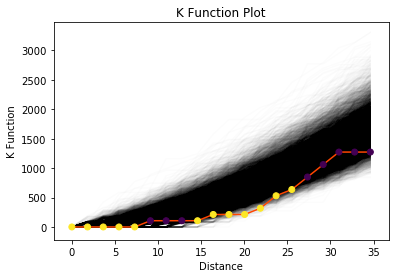

In [17]:
plt.plot(k_test.support, k_test.simulations.T, color='k', alpha=.01)
plt.plot(k_test.support, k_test.statistic, color='orangered')

plt.scatter(k_test.support, k_test.statistic, 
            cmap='viridis', c=k_test.pvalue < .05,
            zorder=4 # make sure they plot on top
           )

plt.xlabel('Distance')
plt.ylabel('K Function')
plt.title('K Function Plot')
plt.show()

Again, we can see that the envelopes are generally above the observed function, meaining that our point pattern is dispersed. We can draw this conclusion because the distances are *too small*, suggesting the pattern is less clustered than otherwise woudl be expected. When points are too regular, their distances tend to be smaller than if they were distributed randomly. 

#### $L$ function - "interevent"

The $L$ function is a scaled version of $K$ function, defined in order to assist with interpretation. The expected value of the $K(d)$ function *increases* with $d$; this makes sense, since the number of pairs of points closer than $d$ will increase as $d$ increases. So, we can define a normalization of $K$ that *removes* this increase as $d$ increases. 

$$L(d) = \sqrt{\frac{K(d)}{\pi}}-d$$

For a pattern that is spatially random, $L(d)$ is $0$ at all $d$ values. So, we can use this standardization to make it easier to visualize the results of the $K$ function:

In [18]:
l_test = ripley.l_test(points, keep_simulations=True)

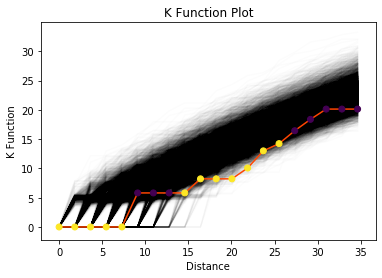

In [19]:
plt.plot(l_test.support, l_test.simulations.T, color='k', alpha=.01)
plt.plot(l_test.support, l_test.statistic, color='orangered')

plt.scatter(l_test.support, l_test.statistic, 
            cmap='viridis', c=l_test.pvalue < .05,
            zorder=4 # make sure they plot on top
           )

plt.xlabel('Distance')
plt.ylabel('K Function')
plt.title('K Function Plot')
plt.show()

## CSR Example

In this example, we are going to generate a point pattern as the "observed" point pattern. This ensures that the data generating process is completely spatially random. Then, we will simulate CSR in the same domain for 100 times and construct evaluate the ripley functions for these simulations. 

In [20]:
import geopandas
df = geopandas.read_file(ps.examples.get_path("vautm17n.shp"))
state = df.geometry.cascaded_union

Generate the point pattern **pp** (size 100) from CSR as the "observed" point pattern.

In [36]:
pattern = ripley.simulate(state, size=100)

before we go any further, let's visualize these simulated values:

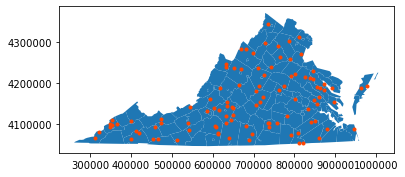

In [37]:
df.plot()
plt.scatter(*pattern.T, color='orangered', marker='.')
plt.show()

And, let's check if there are 100 points:

In [38]:
pattern.shape

(100, 2)

Yep! So, next to simulate a set of realizations in the same manner, we can use the `size` argument again, just like the `numpy.random` simulators. This means that, to simulate $K$ realizations of a pattern of size $N$, then we use `simulate(hull, size=(N,K)`. For just one realization, we can use `size=N`. 

In [39]:
random_realizations = ripley.simulate(state, size=(100,100))

To show the random pattern is truly random, we can visualize all of the points:

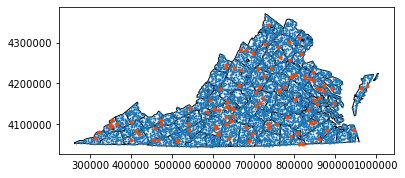

In [59]:
df.plot(facecolor='none', edgecolor='k')
plt.scatter(*random_realizations.T, marker='.', s=2)
plt.scatter(*pattern.T, color='orangered', marker='.')
plt.show()

Let's now compute the `G` function for the observed pattern as well as all the realizations we just made. 

In [67]:
observed_g = ripley.g_function(pattern)
comparison_g = [ripley.g_function(realization, support=observed_g[0]) 
                for realization in random_realizations]

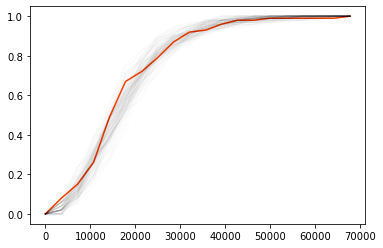

In [68]:
plt.plot(*observed_g, color='orangered')
[plt.plot(*comparison, color='k', alpha=.01) 
 for comparison in comparison_g]
plt.show()

All other functions work identically!